# Installing Libraries and loading the JSON file

In [1]:
#Approach creating task graph
%pip install numpy
%pip install pygad
%pip install deap
%pip install networkx
import numpy as np
import pygad
import random
import json
import networkx as nx
import matplotlib.pyplot as plt
from decimal import Decimal
from copy import deepcopy
from collections import defaultdict

from random import randint, sample
from functools import partial
from deap import base, creator, tools, algorithms





# Open the file from Google Drive
with open("C:/Users/oheka/Desktop/UNI_SIEGEN/PhD/My_codes/example1.json", 'r') as file: 
    json_data = json.load(file)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


# Helper functions

In [2]:
def Read_Parent_AM(json_data):     # Returning a dictionary about the Application graph
  AMx = json_data['application']
  #print("The Parent AM is ",AMx)
  return AMx

def Read_Parent_PM(json_data):     # Returning a dictionary about the Platform graph
  PMx = json_data['platform']
  return PMx


def construct_communication_costs_from_json(json_data):
  messages = json_data['application']['messages']
  communication_costs = {}

  for message in messages:
      sender = message['sender']
      receiver = message['receiver']
      size = message['size']

      if sender not in communication_costs:
          communication_costs[sender] = {receiver: size}
      else:
          communication_costs[sender][receiver] = size

  return communication_costs

def construct_task_dag_from_json(APP_MODEL): # where APP_MODELis an instance from the function Read_Parent_AM(json_data)
    # this function returns 2 lists one for task_dag (list of lists) for the successors
    # Another list tis the wcet_values showing the worst excution times for each job
    jobs = APP_MODEL['jobs']
    messages = APP_MODEL['messages']

    num_tasks = len(jobs)

    # Create a mapping of sender and receiver tasks for each message
    message_mapping = {}
    for message in messages:
        sender = message['sender']
        receiver = message['receiver']
        if sender not in message_mapping:
            message_mapping[sender] = [receiver]
        else:
            message_mapping[sender].append(receiver)

    # Create the task DAG
    task_dag = [[] for _ in range(num_tasks)]

    for job_id, successors in message_mapping.items():
        task_dag[job_id] = successors

    # Extract the WCET values
    wcet_values = [job['processing_times'] for job in jobs]

    return task_dag, wcet_values


def extract_message_list(APP_MODEL):
  # Returns a list of dictionaries for each meassage attribute where the keys for each message will be
  # id,sender,reciever,size
    messages = APP_MODEL['messages']                              # feteching messages (list of dictionaries)
    task_ids = [job['id'] for job in APP_MODEL['jobs']]           # creating a list of task_ids
    message_list = []                                                            # Initializing a list
    for msg in messages:
        sender_id = task_ids.index(msg['sender'])
        receiver_id = task_ids.index(msg['receiver'])
        message_size = msg['size']
        message_id = msg['id']
        message_info = {
            'id': message_id,
            'sender': sender_id,
            'receiver': receiver_id,
            'size': message_size
        }
        message_list.append(message_info)
    return message_list

def compute_makespan(schedule):    # passing the Re-construction function result
    # Extract end times from the schedule
    end_times = [info[2] for info in schedule.values()]
    # The makespan is the maximum end time
    makespan = max(end_times)
    return makespan

def plot_schedule(schedule):
    fig, ax = plt.subplots()

    processors = sorted(list(set([processor for processor, _, _ in schedule.values()])))
    colors = plt.cm.tab10(np.linspace(0, 1, len(processors)))

    for task, (processor, start_time, end_time) in schedule.items():
        color = colors[processor]
        ax.plot([start_time, end_time], [task, task], label=f'Processor {processor}', linewidth=10, marker='o', color=color)

    ax.set_xlabel('Time')
    ax.set_ylabel('Task')

    # Calculate the makespan and set x-axis limit
    makespan = max(end_time for _, (_, _, end_time) in schedule.items())
    ax.set_xlim(0, makespan)

    # Set y-axis ticks and labels
    plt.yticks(range(len(schedule)))
    plt.grid()
    plt.title("Task Schedule")

    # Create a custom legend without duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()


def plot_schedule4(schedule, message_list):     # 23.01.24
    fig, ax = plt.subplots()

    # Define colors for each processor based on the colormap
    processors = sorted(set(proc for proc, _, _ in schedule.values()))
    processor_colors = {proc: plt.cm.tab10(i) for i, proc in enumerate(processors)}

    # Plot the tasks
    for task, (processor, start_time, end_time) in schedule.items():
        ax.barh(task, end_time - start_time, left=start_time, color=processor_colors[processor], edgecolor='black', height=0.6)

    # Plot message transfers with arrows
    for message in message_list:
        sender = message['sender']
        receiver = message['receiver']
        sender_end_time = schedule[sender][2]
        receiver_start_time = schedule[receiver][1]

        # Draw an arrow from the end of the sender task to the start of the receiver task
        ax.annotate("",
                    xy=(receiver_start_time, receiver), xycoords='data',
                    xytext=(sender_end_time, sender), textcoords='data',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                    )

    ax.set_xlabel('Time')
    ax.set_ylabel('Task')
    ax.set_xlim(0, max(end_time for _, (_, _, end_time) in schedule.items()) + 10)  # Extend x-axis
    ax.set_yticks(range(len(schedule)))
    ax.set_yticklabels([f'Task {task}' for task in schedule])
    ax.set_title('Task Schedule')
    ax.grid(True)

    # Create a custom legend with the correct colors
    custom_lines = [plt.Line2D([0], [0], color=processor_colors[proc], lw=4) for proc in processors]
    ax.legend(custom_lines, [f'Processor {proc}' for proc in processors], loc='best')

    plt.tight_layout()
    plt.show()


def construct_graph_from_json(PLAT_MODEL):         # Function for constructing the PM , returns a graph object
    # Extract nodes and links from JSON data
    nodes = PLAT_MODEL['nodes']
    links = PLAT_MODEL['links']

    # Create an empty graph
    graph = nx.Graph()

    # Add nodes to the graph
    for node in nodes:
        node_id = node['id']
        node_type = 'processor' if not node['is_router'] else 'switch'
        graph.add_node(node_id, node_type=node_type)

    # Add edges (links) to the graph
    for link in links:
        start = link['start']
        end = link['end']
        graph.add_edge(start, end)

    return graph

def generate_all_path_indexes_with_costs(graph):                           # Passing the PM as an argument , geneartes all paths between processors in the graph while calcualting the cost
    processors = [node for node, data in graph.nodes(data=True) if data['node_type'] == 'processor']
    # creating a list with the processor nodes ids
    switches = [node for node, data in graph.nodes(data=True) if data['node_type'] == 'switch']
    # creating a list with the switche nodes ids

    def find_all_paths(source, target, path=[]): # A recursive function to find all paths between a give source node and target node, source and target are the iterables from the below for loop
      # This function uses a depth first search (DFS) to explore the paths
        path = path + [source]                    # Appending the "source" node to the path list, to keep track of nodes vistied in the list
        if source == target:
            return [path]
        if source not in graph:                    # checks for node presence in graph
            return []
        paths = []
        for node in graph[source]:                 # iterating through the current neighbors in graph
            if node not in path:
                newpaths = find_all_paths(node, target, path)  # calling the fuction recursively taking the neighbor node as a source node , target node is the same as the old one, path= path calculated so far
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

    path_indexes = {}                             # Initialzing a dict. to store results (paths and costs)
    path_id = 0
    for source in processors:                     # iterating through the processors list in the PM [0,1,2]
        for target in processors:                 # iterating through processors list in PM [0,1,2], done to consider all pairs between source and target nodes
            if source != target:                  # checking if source and target nodes are not the same as we don't need a path from the processor to itself
                all_paths = find_all_paths(source, target)
                all_paths = [path for path in all_paths if any(node in path for node in switches)] # filtering the paths to keep the ones with only one switch node
                if all_paths:
                    for path in all_paths:
                        # Compute the cost as the number of edges in the path
                        path_cost = len(path) - 1                                   # Computing the cost by subtracting 1 from the number of nodes in the path.
                        # Add the path, its ID, and its cost to the result
                        path_indexes[path_id] = {"path": path, "cost": path_cost}
                        path_id += 1
    return path_indexes


# TEST FUNCTIONS

#AMx = Read_Parent_AM(json_data)
#PMx = Read_Parent_PM(json_data)
##print(AMx)
#print(PMx)
#type(AMx)
#successors, processing_times = construct_task_dag_from_json(AMx)
#print(successors)
#print(processing_times)
#message_list = extract_message_list(AMx)
#print(message_list)
#PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMx)
#print(PLATFORM_GRAPH_OBJECT)
#all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
#print(all_path_indexes_with_costs)

# Functions Instances

In [3]:
AMx = Read_Parent_AM(json_data)
PMx = Read_Parent_PM(json_data)
successors, processing_times = construct_task_dag_from_json(AMx)
message_list = extract_message_list(AMx)
PLATFORM_GRAPH_OBJECT = construct_graph_from_json(PMx)
all_path_indexes_with_costs = generate_all_path_indexes_with_costs(PLATFORM_GRAPH_OBJECT)
n_tasks = len(processing_times)

print(processing_times)
print(message_list)
print(all_path_indexes_with_costs)

[2, 4, 4, 5, 4, 3, 2, 5, 4, 3, 2]
[{'id': 0, 'sender': 0, 'receiver': 1, 'size': 6}, {'id': 1, 'sender': 0, 'receiver': 2, 'size': 2}, {'id': 2, 'sender': 0, 'receiver': 3, 'size': 3}, {'id': 3, 'sender': 0, 'receiver': 4, 'size': 4}, {'id': 4, 'sender': 1, 'receiver': 5, 'size': 4}, {'id': 5, 'sender': 1, 'receiver': 9, 'size': 6}, {'id': 6, 'sender': 2, 'receiver': 6, 'size': 2}, {'id': 7, 'sender': 3, 'receiver': 7, 'size': 4}, {'id': 8, 'sender': 4, 'receiver': 8, 'size': 3}, {'id': 9, 'sender': 4, 'receiver': 7, 'size': 2}, {'id': 10, 'sender': 5, 'receiver': 9, 'size': 4}, {'id': 11, 'sender': 6, 'receiver': 10, 'size': 2}, {'id': 12, 'sender': 7, 'receiver': 10, 'size': 3}, {'id': 13, 'sender': 9, 'receiver': 10, 'size': 2}]
{0: {'path': [0, 7, 1], 'cost': 2}, 1: {'path': [0, 7, 8, 2], 'cost': 3}, 2: {'path': [0, 7, 9, 8, 2], 'cost': 4}, 3: {'path': [1, 7, 0], 'cost': 2}, 4: {'path': [1, 7, 8, 2], 'cost': 3}, 5: {'path': [1, 7, 9, 8, 2], 'cost': 4}, 6: {'path': [2, 8, 7, 0], 'co

# Features Update based on the Incremented AM

In [4]:
New_tasks_list = []                          # Initializing a list for the upcoming tasks
new_message_list = []
# Incremented_Message_list =[]                 # Intilaizing a list to have the incremnted features
# Incremented_Processing_times = []            # Intilaizing a list to have the incremnted features
Incremented_Message_list = [x for x in message_list]               # Will be used when running the GA used for estimating the deadline 
Incremented_Processing_times=[x for x in processing_times]       # Will be used when running the GA used for estimating the deadline 
#with open("C:/Users/oheka/Desktop/UNI_SIEGEN/PhD/My_codes/scenarios/example_N1.json", 'r') as file_5tasks:
with open("C:/Users/oheka/Desktop/UNI_SIEGEN/PhD/My_codes/example_N1_10T_Updated.json", 'r') as file_5tasks: 
 
    json_data_inc = json.load(file_5tasks)

for x in json_data_inc["application"]["jobs"]:
     New_tasks_list.append(x)
# for x in New_tasks_list:
for x in json_data_inc["application"]["jobs"]:
     Incremented_Processing_times.append(x["processing_times"])    # Updating the list to incroprate the times from the added AM

for x in json_data_inc["application"]["messages"]:
     Incremented_Message_list.append(x)                             # Updating the list to incroprate the message attributes from the added AM
    
# # Printing the updated AM parameters
# print(New_tasks_list)
print(Incremented_Processing_times)
print(Incremented_Message_list)
len(Incremented_Processing_times)

[2, 4, 4, 5, 4, 3, 2, 5, 4, 3, 2, 3, 3, 3, 2, 5, 1, 10, 7, 3, 10]
[{'id': 0, 'sender': 0, 'receiver': 1, 'size': 6}, {'id': 1, 'sender': 0, 'receiver': 2, 'size': 2}, {'id': 2, 'sender': 0, 'receiver': 3, 'size': 3}, {'id': 3, 'sender': 0, 'receiver': 4, 'size': 4}, {'id': 4, 'sender': 1, 'receiver': 5, 'size': 4}, {'id': 5, 'sender': 1, 'receiver': 9, 'size': 6}, {'id': 6, 'sender': 2, 'receiver': 6, 'size': 2}, {'id': 7, 'sender': 3, 'receiver': 7, 'size': 4}, {'id': 8, 'sender': 4, 'receiver': 8, 'size': 3}, {'id': 9, 'sender': 4, 'receiver': 7, 'size': 2}, {'id': 10, 'sender': 5, 'receiver': 9, 'size': 4}, {'id': 11, 'sender': 6, 'receiver': 10, 'size': 2}, {'id': 12, 'sender': 7, 'receiver': 10, 'size': 3}, {'id': 13, 'sender': 9, 'receiver': 10, 'size': 2}, {'id': 14, 'sender': 12, 'receiver': 11, 'size': 6}, {'id': 15, 'sender': 13, 'receiver': 12, 'size': 9}, {'id': 16, 'sender': 14, 'receiver': 11, 'size': 3}, {'id': 17, 'sender': 14, 'receiver': 12, 'size': 6}, {'id': 18, 'se

21

# Schedule Reconstruction (Maximizing the slack)

In [51]:
def reconstruct_schedule_with_precedence_U1(task_allocation, node_list, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering):
    # Create a deep copy of the message_list to avoid modifying the original data
    message_list_copy = deepcopy(message_list)            #creating a copy of the message list

    num_processors = max(task_allocation) + 1             # specifing the number of processors
    processors = [[] for _ in range(num_processors)]      # creating a list of empty lists of size = processors

    for task, processor in enumerate(task_allocation):    # Appending the list of processor
        processors[processor].append(task)


    schedule = {}                                         # Initializing a dictionary for the new schedule.
    task_completion_times = [0] * len(node_list)          # Initializing a list of zeros with size = node list
    message_dict = defaultdict(list)                      # creating an instance of defaultdict, it allows define a default value for keys that do not yet exist in the dictionary.
    for i in range(n_tasks):
        message_dict[i] = []                              # Initializing with all potential receivers


    # Create a dictionary to map message ID to priority
    #message_priority_dict = {idx: priority for priority, idx in enumerate(message_priority_ordering)}
    # Modify the message_priority_dict to use actual message IDs
    message_priority_dict = {message_id: priority for priority, message_id in enumerate(message_priority_ordering)}       # Mapping messages to priorities


    for idx, message in enumerate(message_list_copy):
        # Decode the message path index to the corresponding path index
        path_id = message_path_index[idx]
        path = all_path_indexes_with_costs[path_id]["path"]

        path_cost= all_path_indexes_with_costs[path_id]["cost"]

        # Adjust the size of the message with the cost of the path
        message["size"] += path_cost

        # Append a tuple containing the sender, message size, and message priority to the receiver's list in the message_dict
        #message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[idx]))

        # Use message["id"] to get the priority from message_priority_dict
        message_dict[message["receiver"]].append((message["sender"], message["size"], message_priority_dict[message["id"]]))

    # Sort each receiver's list in message_dict by message priority
    for receiver, messages in message_dict.items():
        message_dict[receiver] = sorted(messages, key=lambda x: x[2])

    current_time_per_processor = [0] * num_processors                 # initilaizing a list of zeros of size = No. of processors
    completed_tasks = set()                                           # creating an empty set for the completed tasks
    ready_tasks = set(range(len(node_list)))                          # A set of random numbers of size = length of node list


    first_task_scheduled_on_processor = [True] * num_processors

    while ready_tasks:
        task = ready_tasks.pop()
        task_id = node_list[task]
        processor = task_allocation[task]
        i = processor

        predecessors = message_dict[task_id]
        if all(p in completed_tasks for p, _, _ in predecessors):
            if predecessors:
                start_time = max(current_time_per_processor[i], max(task_completion_times[sender] + size for sender, size, _ in predecessors))
            else:
                start_time = current_time_per_processor[i]

            
            if not first_task_scheduled_on_processor[i]:                   # Checking if it is the first task to be scheduled on a processor
                buffer_time = start_time - current_time_per_processor[i]   # calculating the actual buffer time
                if buffer_time < 6:                                       # comparing the actual buffer time 
                    start_time += 6- buffer_time
            else:
                first_task_scheduled_on_processor[i] = False

            end_time = start_time + processing_times[task_id]
            schedule[task_id] = (i, start_time, end_time)
            task_completion_times[task_id] = end_time

            current_time_per_processor[i] = end_time
            completed_tasks.add(task_id)
        else:
            ready_tasks.add(task)

    return schedule

# Generating Estimate Schedule 

c:\Users\oheka\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


The initial Indidvidual is [10, 6, 20, 5, 4, 7, 15, 16, 17, 11, 3, 2, 12, 13, 19, 1, 8, 0, 14, 9, 18]
The randomly initialized task allocation looks as the follows [2, 2, 1, 2, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2, 1]
The randomly initialized message path looks as the follows [9, 5, 3, 7, 5, 0, 8, 5, 4, 8, 8, 8, 3, 6, 8, 7, 9, 6, 1, 3, 1, 6, 5, 1, 3, 1, 1]
The random priority ordering looks as follows [8, 14, 10, 2, 22, 6, 0, 24, 25, 15, 11, 19, 17, 13, 16, 18, 4, 5, 20, 21, 12, 7, 1, 3, 23, 9, 26]
The initial combined individual is [10, 2, 20, 5, 18, 17, 7, 19, 6, 14, 1, 3, 15, 4, 11, 8, 12, 16, 13, 9, 0, 2, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 1, 5, 3, 5, 1, 3, 4, 5, 3, 2, 6, 9, 8, 5, 9, 1, 1, 3, 1, 1, 3, 2, 4, 0, 4, 0, 3, 6, 17, 14, 16, 23, 24, 12, 20, 0, 4, 11, 3, 8, 25, 10, 21, 22, 7, 18, 26, 5, 13, 15, 1, 9, 2, 19]
The initial population is [[15, 20, 7, 4, 14, 17, 11, 18, 0, 16, 2, 6, 13, 19, 10, 12, 3, 1, 8, 5, 9, 2, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1,

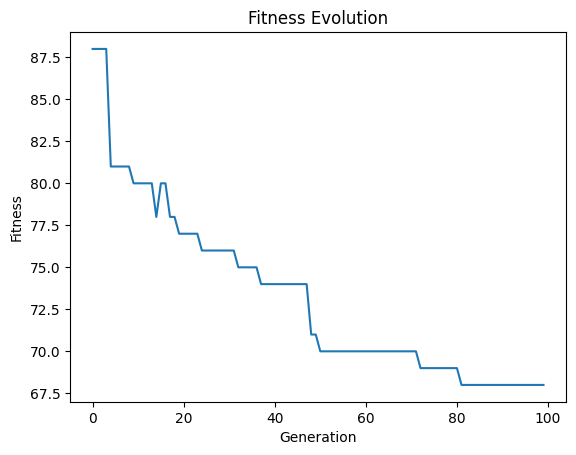

The final schedule is {0: (2, 0, 2), 20: (1, 0, 10), 16: (0, 0, 1), 1: (1, 16, 20), 3: (0, 7, 12), 17: (2, 9, 19), 19: (0, 18, 21), 14: (1, 26, 28), 4: (0, 27, 31), 15: (2, 25, 30), 18: (2, 36, 43), 2: (0, 37, 41), 7: (0, 47, 52), 13: (1, 35, 38), 5: (1, 44, 47), 9: (2, 53, 56), 6: (0, 58, 60), 10: (0, 66, 68), 8: (2, 62, 66), 12: (1, 53, 56), 11: (1, 65, 68)}


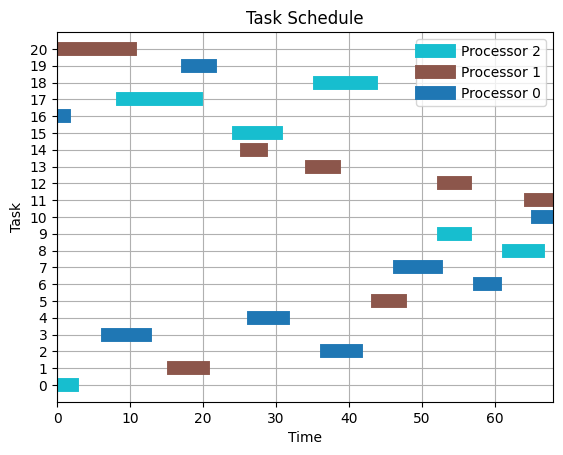

The final schedule makespan is 68
The Final Genome for this schdule is [[18, 11, 2, 12, 9, 7, 0, 20, 13, 10, 5, 16, 1, 3, 17, 6, 19, 14, 8, 4, 15], [2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 2], [0, 4, 0, 4, 2, 3, 0, 0, 0, 2, 0, 1, 1, 1, 1, 3, 2, 0, 0, 3, 1, 1, 0, 0, 1, 6, 4], [16, 13, 2, 23, 12, 18, 14, 1, 4, 25, 19, 5, 20, 9, 22, 24, 3, 17, 11, 6, 21, 8, 26, 0, 7, 10, 15]]


In [52]:
def Deadline_Estimation_GA(processing_times, message_list, all_path_indexes_with_costs):
  best_fitness_values = []                                        # initializing a list to include the best fitnessess values

  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines = len(processors) - 1                                # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)


  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  #print ('The Initial Schedule looks as {}'.format(reconstruct_schedule(toolbox.processor_allocation(), toolbox.task_order())))     # OMAR yaaaas

  ############################################################################################################################################################

  ####################################################### Evaluation, selection, mating, and mutation methods ################################################

  #########compute makespan function ################################################
  def compute_makespan(schedule):
      # Extract end times from the schedule
      end_times = [info[2] for info in schedule.values()]
      # The makespan is the maximum end time
      makespan = max(end_times)
      return makespan
  ################################################################

  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      schedule = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      makespan  = compute_makespan(schedule)
      fitness = (makespan)
      #fitness =  (makespan)

      #print("Makespan over time is %s, %s", makespan)
      #scheduleR = reconstruct_schedule(processor_allocation, task_order)
      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function

  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2

  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 100 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
      best_fitness_values.append(tools.selBest(pop, 1)[0].fitness.values[0])

  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

  plt.plot(range(NGEN), best_fitness_values)
  plt.xlabel('Generation')
  plt.ylabel('Fitness')
  plt.title('Fitness Evolution')
  plt.show()




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
  print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome



Initial_schedule, Final_genome_initial_schedule= Deadline_Estimation_GA(Incremented_Processing_times, Incremented_Message_list, all_path_indexes_with_costs)




makespan_initial_schedule  = compute_makespan(Initial_schedule)

#plot_schedule4(scheduleFinal,message_list)
plot_schedule(Initial_schedule)
print('The final schedule makespan is {}'.format(makespan_initial_schedule))
print("The Final Genome for this schdule is {}".format(Final_genome_initial_schedule))

# Deadline Constraint

In [ ]:
Base_schedule_makespan = compute_makespan(Initial_schedule)
Application_Deadline = round((0.2*Base_schedule_makespan)+Base_schedule_makespan)
print(Application_Deadline)

# Base Schedule (Makespan fitness)

The initial Indidvidual is [3, 4, 8, 9, 1, 10, 5, 7, 0, 2, 6]
The randomly initialized task allocation looks as the follows [2, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0]
The randomly initialized message path looks as the follows [6, 4, 4, 6, 1, 3, 3, 0, 8, 9, 8, 5, 4, 7]
The random priority ordering looks as follows [3, 4, 2, 0, 10, 1, 11, 13, 12, 8, 5, 9, 6, 7]
The initial combined individual is [3, 9, 7, 5, 1, 4, 2, 10, 8, 0, 6, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 5, 0, 0, 3, 9, 6, 2, 9, 6, 1, 7, 9, 2, 5, 10, 7, 12, 5, 8, 4, 6, 11, 1, 13, 3, 9, 2, 0]
The initial population is [[7, 8, 3, 2, 10, 1, 5, 6, 0, 4, 9, 2, 2, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 5, 2, 9, 8, 7, 7, 6, 2, 8, 3, 3, 8, 4, 10, 3, 1, 9, 11, 5, 12, 13, 8, 7, 2, 6, 0], [6, 2, 9, 4, 3, 0, 7, 8, 10, 5, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 2, 4, 7, 5, 6, 0, 1, 0, 2, 8, 3, 5, 7, 2, 11, 1, 4, 9, 7, 2, 13, 3, 6, 5, 0, 12, 8, 10], [5, 8, 2, 4, 3, 10, 6, 0, 9, 1, 7, 1, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 6, 0, 6, 3, 8, 9, 2, 7, 3, 6, 1, 1, 0, 9, 10, 4

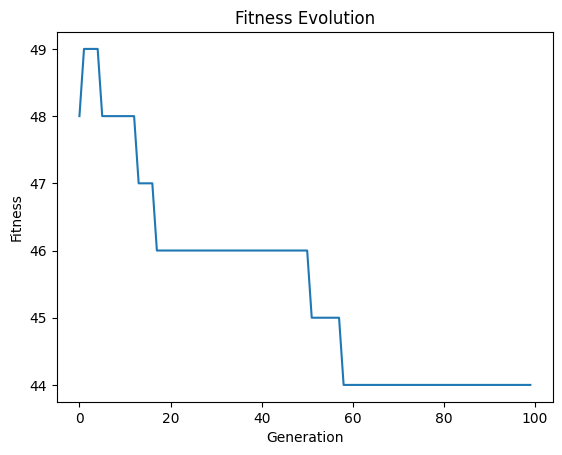

The final schedule is {0: (1, 0, 2), 1: (1, 10, 14), 3: (2, 7, 12), 2: (0, 7, 11), 6: (0, 19, 21), 4: (2, 20, 24), 7: (0, 29, 34), 5: (1, 22, 25), 8: (2, 32, 36), 9: (1, 33, 36), 10: (0, 42, 44)}


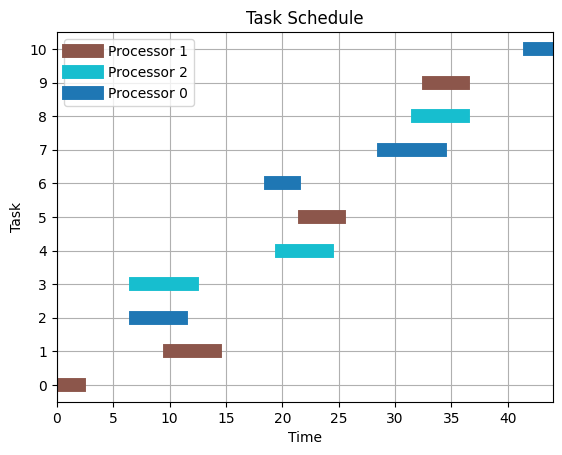

The final schedule makespan is 44
The Final Genome for this schdule is [[1, 3, 2, 6, 7, 4, 10, 0, 5, 8, 9], [1, 2, 0, 0, 0, 2, 0, 1, 1, 2, 1], [3, 1, 0, 0, 7, 8, 0, 4, 0, 4, 6, 0, 7, 4], [6, 11, 13, 2, 12, 8, 10, 1, 5, 9, 4, 7, 0, 3]]


In [40]:
def generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs):
  best_fitness_values = []                                        # initializing a list to include the best fitnessess values

  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines = len(processors) - 1                                # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)


  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  #print ('The Initial Schedule looks as {}'.format(reconstruct_schedule(toolbox.processor_allocation(), toolbox.task_order())))     # OMAR yaaaas

  ############################################################################################################################################################

  ####################################################### Evaluation, selection, mating, and mutation methods ################################################

  #########compute makespan function ################################################
  def compute_makespan(schedule):
      # Extract end times from the schedule
      end_times = [info[2] for info in schedule.values()]
      # The makespan is the maximum end time
      makespan = max(end_times)
      return makespan
  ################################################################

  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      schedule = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      makespan  = compute_makespan(schedule)
      fitness = (makespan)
      #fitness =  (makespan)

      #print("Makespan over time is %s, %s", makespan)
      #scheduleR = reconstruct_schedule(processor_allocation, task_order)
      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function


  #toolbox.register("mate", tools.cxTwoPoint)


  # mutation operators
  # def mutation_task_order(individual, task_order_len):
  #     task_order = individual[:task_order_len] # permutation encoding
  #     random.shuffle(task_order) # Shuffle the indexes of task_order
  #     individual[:task_order_len] = task_order
  #     return individual,
  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2

  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 100 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
      best_fitness_values.append(tools.selBest(pop, 1)[0].fitness.values[0])

  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

  plt.plot(range(NGEN), best_fitness_values)
  plt.xlabel('Generation')
  plt.ylabel('Fitness')
  plt.title('Fitness Evolution')
  plt.show()




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
  print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome



scheduleFinal, Final_genome= generate_schedule_base_schedule(processing_times, message_list, all_path_indexes_with_costs)

s1_base = scheduleFinal


makespanFinal  = compute_makespan(scheduleFinal)

#plot_schedule4(scheduleFinal,message_list)
plot_schedule(scheduleFinal)
print('The final schedule makespan is {}'.format(makespanFinal))
print("The Final Genome for this schdule is {}".format(Final_genome))

In [41]:
scheduleFinal = {0: (1, 0, 2), 1: (1, 10, 14), 3: (2, 7, 12), 2: (0, 7, 11), 6: (0, 19, 21), 4: (2, 20, 24), 7: (0, 29, 34), 5: (1, 22, 25), 8: (2, 32, 36), 9: (1, 33, 36), 10: (0, 42, 44)}


# GA- "Incremented tasks" WITH MODIFIED OBJECTIVE FUNCTION

## GA successor schedule 

The initial Indidvidual is [19, 9, 8, 2, 11, 5, 1, 13, 14, 0, 18, 3, 12, 16, 10, 7, 6, 20, 17, 15, 4]
The randomly initialized task allocation looks as the follows [2, 0, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2]
The randomly initialized message path looks as the follows [4, 7, 9, 9, 0, 0, 7, 4, 4, 3, 3, 1, 6, 7, 8, 3, 2, 7, 7, 4, 3, 1, 3, 5, 3, 4, 9]
The random priority ordering looks as follows [4, 25, 23, 5, 3, 9, 1, 15, 21, 8, 0, 2, 12, 19, 17, 26, 10, 6, 20, 22, 24, 7, 11, 14, 18, 16, 13]
The initial combined individual is [13, 18, 19, 15, 9, 3, 20, 11, 4, 17, 1, 8, 0, 10, 5, 16, 2, 14, 7, 12, 6, 1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 0, 2, 0, 8, 6, 9, 5, 4, 5, 0, 0, 0, 9, 2, 3, 5, 6, 5, 8, 8, 3, 4, 6, 8, 1, 5, 9, 4, 6, 22, 20, 3, 8, 11, 0, 6, 16, 18, 26, 5, 21, 10, 17, 15, 19, 9, 12, 14, 1, 13, 23, 25, 7, 2, 4, 24]
The initial population is [[14, 2, 19, 1, 10, 20, 7, 8, 18, 4, 16, 6, 3, 11, 15, 17, 0, 13, 5, 12, 9, 1, 1, 1, 0, 0, 2, 1, 1, 0, 2, 1,

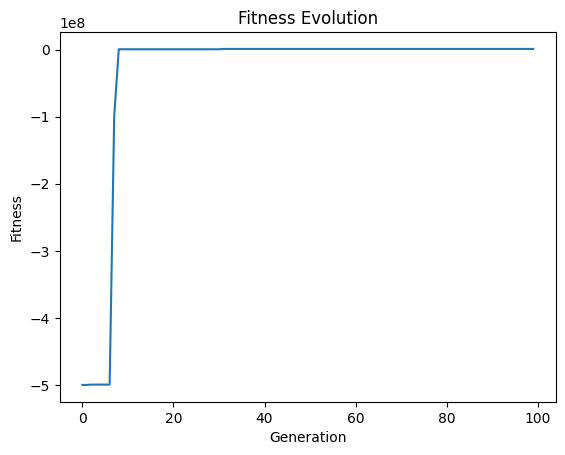

The final schedule is {16: (2, 0, 1), 15: (2, 9, 14), 20: (0, 0, 10), 19: (0, 16, 19), 0: (1, 0, 2), 17: (1, 9, 19), 14: (1, 25, 27), 18: (1, 33, 40), 4: (2, 20, 24), 1: (0, 25, 29), 2: (1, 46, 50), 3: (2, 30, 35), 13: (0, 35, 38), 6: (2, 56, 58), 5: (0, 44, 47), 8: (0, 53, 57), 7: (1, 56, 61), 12: (0, 63, 66), 9: (1, 67, 70), 11: (1, 76, 79), 10: (0, 74, 76)}


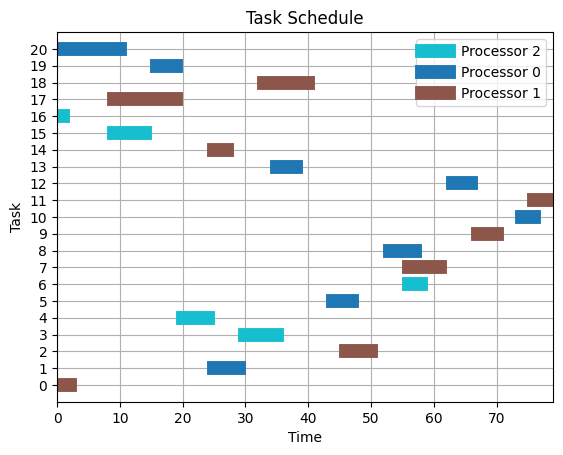

The final schedule makespan is 79
The Final Genome for this schdule is [[16, 10, 15, 5, 9, 12, 11, 7, 6, 4, 20, 1, 2, 19, 3, 0, 13, 17, 14, 18, 8], [2, 0, 2, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0], [1, 1, 0, 9, 7, 2, 7, 5, 2, 1, 1, 2, 0, 3, 0, 7, 5, 8, 0, 1, 1, 1, 0, 1, 8, 0, 3], [0, 15, 24, 7, 23, 26, 16, 3, 5, 19, 8, 4, 20, 22, 2, 17, 12, 18, 1, 13, 10, 11, 21, 25, 14, 6, 9]]


In [58]:
previous_schedule = scheduleFinal    # Accessing the previous schedule

def generate_schedule_Successor_schedule(processing_times, message_list, all_path_indexes_with_costs,previous_schedule):
  best_fitness_values = [] # initializing a list to include the best fitnessess values

  #creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  #creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.


  creator.create("FitnessMax", base.Fitness, weights=(1.0,))
  creator.create("Individual", list, fitness=creator.FitnessMax)

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines = len(processors) - 1                                # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)


  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  ####################################################### Evaluation, selection, mating, and mutation methods ################################################


  def jaccard_similarity(s1, s2):
    common_keys = s1.keys() & s2.keys()
    #print ("the common keys are {}".format(common_keys))

    # Create sets only for those keys which are present in both dictionaries
    set_s1 = set((key, s1[key][0], s1[key][1], s1[key][2]) for key in common_keys)
    #print("the first set is {}".format (set_s1))
    set_s2 = set((key, s2[key][0], s2[key][1], s2[key][2]) for key in common_keys)
    #print("the second set is {}".format(set_s2))

    intersection = len(set_s1.intersection(set_s2))
    #print ("the intersection is {}".format(intersection))
    union = len(set_s1.union(set_s2))
    #print("the union is {}".format(union))

    similarity_index = intersection / union

    return similarity_index

  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs,previous_schedule):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      schedule = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      #makespan  = compute_makespan(schedule)
      # print("The new schedule is ", schedule)
      stability_score = jaccard_similarity(schedule, previous_schedule)
      previous_schedule_makespan = compute_makespan(previous_schedule)
      New_schedule_makespan = compute_makespan(schedule)
      Application_Deadline = round(68*1.2)
      lateness = New_schedule_makespan - Application_Deadline
      print("the stability score is : {}".format(stability_score))
      if lateness > 0:
        penalty = -100000000 *lateness  #  large negative value to  penalize lateness
      else:
        penalty = 0  # No penalty if the schedule is within the deadline

      # Fitness calculation: Maximize stability score, penalize if deadline is exceeded
      fitness =(10000000*stability_score)+ penalty  # Adding penalty since it's negative; it will reduce the fitness for lateness
    

      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs,previous_schedule=previous_schedule)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function

  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2
  #CXPB, MUTPB = 0.8, 0.2

  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 100 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
      best_fitness_values.append(tools.selBest(pop, 1)[0].fitness.values[0])
  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]

  plt.plot(range(NGEN), best_fitness_values)
  plt.xlabel('Generation')
  plt.ylabel('Fitness')
  plt.title('Fitness Evolution')
  plt.show()
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
  #scheduleFinal = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)

  print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome


scheduleFinal_new_obj, Final_genome= generate_schedule_Successor_schedule(Incremented_Processing_times, Incremented_Message_list, all_path_indexes_with_costs,previous_schedule)
Succ_Schedule_makespan = compute_makespan(scheduleFinal_new_obj)
plot_schedule(scheduleFinal_new_obj)
print('The final schedule makespan is {}'.format(Succ_Schedule_makespan))
print("The Final Genome for this schdule is {}".format(Final_genome))

# Makespan as Objective function

The initial Indidvidual is [4, 2, 1, 11, 5, 14, 7, 8, 9, 6, 15, 16, 12, 13, 20, 3, 10, 17, 18, 0, 19]
The randomly initialized task allocation looks as the follows [0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2]
The randomly initialized message path looks as the follows [1, 8, 3, 9, 8, 0, 4, 6, 7, 9, 0, 9, 3, 5, 7, 5, 6, 2, 2, 9, 5, 6, 2, 4, 6, 7, 8]
The random priority ordering looks as follows [3, 20, 16, 26, 6, 8, 14, 2, 12, 0, 7, 22, 25, 10, 1, 18, 5, 17, 23, 4, 9, 19, 11, 13, 21, 15, 24]
The initial combined individual is [8, 10, 7, 0, 15, 20, 16, 19, 5, 2, 9, 6, 13, 1, 11, 3, 14, 18, 17, 12, 4, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 2, 2, 1, 9, 9, 1, 2, 3, 2, 9, 1, 4, 8, 2, 7, 9, 4, 5, 4, 4, 2, 0, 7, 5, 8, 4, 1, 7, 8, 9, 6, 5, 2, 3, 23, 14, 4, 11, 20, 25, 18, 9, 16, 7, 22, 24, 17, 12, 13, 0, 26, 19, 21, 8, 15, 1, 10]
The initial population is [[6, 12, 20, 8, 14, 10, 19, 5, 1, 7, 9, 13, 4, 3, 15, 11, 16, 0, 18, 2, 17, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2,

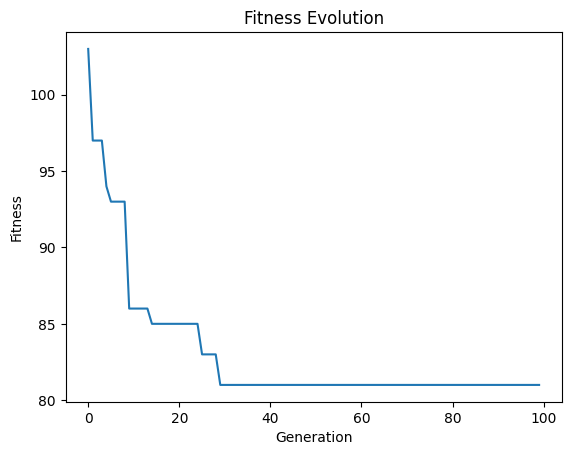

The final schedule is {0: (1, 0, 2), 1: (1, 10, 14), 16: (2, 0, 1), 20: (0, 0, 10), 17: (1, 22, 32), 3: (2, 9, 14), 14: (1, 40, 42), 19: (2, 22, 25), 4: (0, 18, 22), 15: (2, 33, 38), 2: (0, 30, 34), 5: (0, 42, 45), 8: (0, 53, 57), 13: (1, 51, 54), 7: (0, 65, 70), 9: (1, 62, 65), 18: (2, 46, 53), 6: (1, 73, 75), 12: (2, 66, 69), 10: (2, 79, 81), 11: (0, 78, 81)}


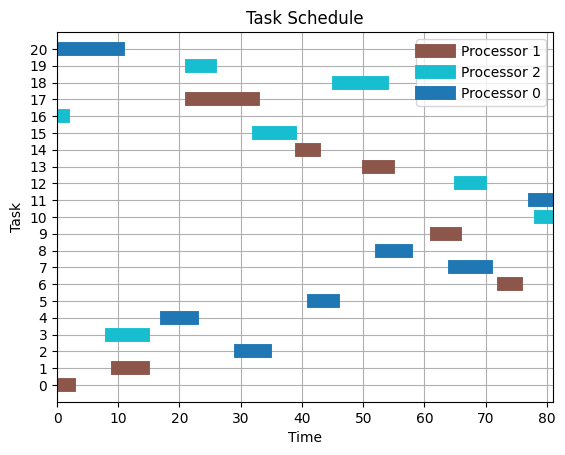

The final schedule makespan is 81
The Final Genome for this schdule is [[7, 4, 12, 6, 15, 10, 2, 9, 11, 5, 0, 8, 1, 13, 16, 20, 17, 3, 18, 14, 19], [0, 0, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 1, 2, 2, 1, 2], [0, 7, 0, 6, 1, 1, 1, 5, 3, 4, 1, 0, 5, 3, 0, 1, 3, 9, 9, 0, 4, 3, 1, 8, 0, 5, 3], [5, 22, 7, 6, 23, 20, 2, 21, 9, 8, 26, 12, 4, 18, 3, 16, 13, 25, 14, 15, 0, 19, 24, 1, 10, 11, 17]]


In [47]:
def generate_schedule_Successor_schedule_makespan(processing_times, message_list, all_path_indexes_with_costs,previous_schedule):

  best_fitness_values = [] # initializing a list to include the best fitnessess values

  creator.create("FitnessMin", base.Fitness, weights=(-1.0,))     # creating a FitnessMin class for minimization and setting the weights to (-1.0,).
  creator.create("Individual", list, fitness=creator.FitnessMin)  # creating the Individual class as a list with the FitnessMin class as the fitness attribute.

  toolbox = base.Toolbox()

  #parameters
  num_tasks = len(processing_times)                               # No of jobs in task graph
  nodes = json_data["platform"]["nodes"]                          # Accessing the nodes of the Platform model
  processors = [node for node in nodes if not node["is_router"]]  # Creating  a list of the processors in the Platform model.
  num_machines = len(processors) - 1                                # A variable specifing the number of machines
  num_message = len(message_list)                                 # A varible = No. of messages
  num_paths = len(all_path_indexes_with_costs)                    # total number of paths

  # Define the initialization function for the individual
  def init_individual():
      return random.sample(range(num_tasks), num_tasks)           # returns a list of random numbers in the range of num_tasks

  print('The initial Indidvidual is {}'.format(init_individual()))  # OMAR

  # Register the initialization function in the DEAP toolbox
  toolbox.register("task_order", init_individual)


  # Processor_allocation value encoding
  def processor_allocation(n_task, n_machines):
      return [random.randint(0, num_machines) for _ in range(n_task)]   # A random list , contains the allocation of each job with the corresponding task
  toolbox.register("processor_allocation", processor_allocation, n_task=num_tasks, n_machines=num_machines)
  HH = toolbox.processor_allocation()                                                     # OMAR
  print('The randomly initialized task allocation looks as the follows {}'.format(HH))    # OMAR

  # Message_path_index value encoding
  def message_path_index(n_messages, max_all_path_index):
      return [random.randint(0, max_all_path_index - 1) for _ in range(n_messages)]  # Ensure indices are within range
      # returns a list of random numbers of size = n_messages and values ranging from (0, max_all_path_index - 1).

  toolbox.register("message_path_index", message_path_index, n_messages=num_message, max_all_path_index= num_paths)

  print('The randomly initialized message path looks as the follows {}'.format(toolbox.message_path_index()))    # OMAR


  # Message_priority_ordering permutation encoding
  def message_priority_ordering(n_messages):
      return random.sample(range(n_messages), n_messages)         # returns a list of size = n_messages, showing the messages ordering
  toolbox.register("message_priority_ordering", message_priority_ordering, n_messages=num_message)

  print('The random priority ordering looks as follows {}'.format(toolbox.message_priority_ordering()))        # OMAR

  # Combined Individual
  def create_individual():
      individual = []
      individual.extend(toolbox.task_order())
      individual.extend(toolbox.processor_allocation())
      individual.extend(toolbox.message_path_index())
      individual.extend(toolbox.message_priority_ordering())
      return individual
  # To view the whole indivudual
  #individual = create_individual()
  #print("Individual:", individual)
  toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

  print('The initial combined individual is {}'.format(toolbox.individual()))                  # OMAR

  # Population initialization
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)
  print('The initial population is {}'.format(toolbox.population(n=100)))

  def reconstruct_schedule(processor_allocation, task_order):
      # Initialize the schedule as a dictionary of empty lists
      # where each key is a processor id
      schedule = {i: [] for i in range(max(processor_allocation) + 1)}

      # Iterate over tasks in their given order
      for task in task_order:
          # Assign each task to its processor
          schedule[processor_allocation[task]].append(task)



      return schedule
  #print ('The Initial Schedule looks as {}'.format(reconstruct_schedule(toolbox.processor_allocation(), toolbox.task_order())))     # OMAR yaaaas

  ############################################################################################################################################################

  ####################################################### Evaluation, selection, mating, and mutation methods ################################################

  #########compute makespan function ################################################
  def compute_makespan(schedule):
      # Extract end times from the schedule
      end_times = [info[2] for info in schedule.values()]
      # The makespan is the maximum end time
      makespan = max(end_times)
      return makespan
  ################################################################



  # Define the evaluation function
  def evaluate(individual, processing_times, message_list, all_path_indexes_with_costs,previous_schedule):
      # Split individual into its components
      task_order_len = num_tasks                  # An Integer with the number of the tasks
      processor_allocation_len = num_tasks        # Integer
      message_path_index_len = num_message        # Integer
      message_priority_ordering_len = num_message # Integer
      task_order = individual[:task_order_len]    # permuation encoding, Acessing the first portion of the chromosome
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding acessing the second portion of chromosomes
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      # print("task_order ================", task_order)
      # print("processor_allocation ================", processor_allocation)
      # print("message_path_index ================", message_path_index)
      # print("message_priority_ordering ================", message_priority_ordering)
      #schedule = reconstruct_schedule_with_precedenceX(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
      schedule = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)

      makespan  = compute_makespan(schedule)
      #print("The new schedule is ", schedule)
      #differences = calculate_differences(schedule, previous_schedule)
      #print("the differences are : {}".format(differences))
      #makespan =+ differences
      fitness =  (makespan)
      #fitness = makespan
      #print("Makespan over time is %s, %s", makespan)
      #scheduleR = reconstruct_schedule(processor_allocation, task_order)
      return fitness,

  # Register the evaluation function
  toolbox.register("evaluate", evaluate,processing_times=processing_times,
                  message_list=message_list, all_path_indexes_with_costs=all_path_indexes_with_costs,previous_schedule=previous_schedule)

  # Register selection operator
  toolbox.register("select", tools.selTournament, tournsize=3) # Applying tournament selection, tournsize=3
                                                               # meaning three individuals will be randomly selected from the population,
                                                               # and the best one among them will be chosen as a parent for the next generation.


  # Register the crossover operator (Permutation encoded)
  def mate(ind1, ind2, task_order_len):
      # Copy the individuals
      child1, child2 = toolbox.clone(ind1), toolbox.clone(ind2) # creating copies from ind1 and ind2 to preserve original originals while crossover and mutation.

      # Apply PMX crossover to task_order
      tools.cxPartialyMatched(child1[:task_order_len], child2[:task_order_len]) # Applying partially matched crossover method

      # Return the modified individuals
      return child1, child2

  toolbox.register("mate", mate, task_order_len=num_tasks)                # Register the crossover function


  #toolbox.register("mate", tools.cxTwoPoint)


  # mutation operators
  # def mutation_task_order(individual, task_order_len):
  #     task_order = individual[:task_order_len] # permutation encoding
  #     random.shuffle(task_order) # Shuffle the indexes of task_order
  #     individual[:task_order_len] = task_order
  #     return individual,
  def mutation_task_order(individual, task_order_len):
      task_order = individual[:task_order_len]  # permutation encoding
      indices = random.sample(range(task_order_len), 2)  # Select two random indices
      task_order[indices[0]], task_order[indices[1]] = task_order[indices[1]], task_order[indices[0]]  # Swap the elements at the selected indices
      individual[:task_order_len] = task_order
      return individual,

  def mutation_processor_allocation(individual,task_order_len, processor_allocation_len): # (task_order_len = processor_allocation_len)
      processor_allocation = individual[task_order_len:task_order_len + processor_allocation_len] # value encoding
      tools.mutUniformInt(processor_allocation, low=0, up=1, indpb=0.05) # Mutate processor_allocation by uniformly changing its elements with an indpb chance
      individual[task_order_len:task_order_len + processor_allocation_len] = processor_allocation
      return individual,

  def mutation_message_path_index(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_path_index = individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] # value encoding
      tools.mutUniformInt(message_path_index, low=0, up=1, indpb=0.05) # Mutate message_path_index by uniformly changing its elements with an indpb chance
      individual[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] = message_path_index
      return individual,

  def mutation_message_priority_ordering(individual, task_order_len, processor_allocation_len, message_path_index_len):
      message_priority_ordering = individual[task_order_len + processor_allocation_len + message_path_index_len :] # permuation encoding
      tools.mutShuffleIndexes(message_priority_ordering, indpb=0.05) # Mutate message_priority_ordering by shuffling its indexes with an indpb chance
      individual[task_order_len + processor_allocation_len + message_path_index_len :] = message_priority_ordering
      return individual,

  # register the mutation operators
  toolbox.register("mutate_task_order", mutation_task_order, task_order_len = num_tasks)
  toolbox.register("mutate_processor_allocation", mutation_processor_allocation, task_order_len = num_tasks, processor_allocation_len = num_tasks)
  toolbox.register("mutate_message_path_index", mutation_message_path_index, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)
  toolbox.register("mutate_message_priority_ordering", mutation_message_priority_ordering, task_order_len = num_tasks, processor_allocation_len = num_tasks, message_path_index_len = num_message)

  ######################################################
  # Create an initial population
  pop = toolbox.population(n=100)
  # Evaluate the entire population
  fitnesses = map(toolbox.evaluate, pop)
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit
  # Crossover probability and mutation probability
  CXPB, MUTPB = 0.3, 0.2
  #CXPB, MUTPB = 0.8, 0.2




  # Extract all the fitnesses of
  fits = [ind.fitness.values[0] for ind in pop]

  NGEN = 100 #Number of generations
  # Begin the evolution
  for g in range(NGEN):
      # A new generation
      offspring = toolbox.select(pop, len(pop)) # Apply the tournmnet selection , 3 individulas will be selected
      # Clone the selected individuals
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
          if random.random() < CXPB:
              toolbox.mate(child1, child2) # Applying crossover for Permutation encoding (task orders)
              del child1.fitness.values
              del child2.fitness.values
      # mutation
      for mutant in offspring:
          if random.random() < MUTPB:
              toolbox.mutate_task_order(mutant)
              toolbox.mutate_processor_allocation(mutant)
              toolbox.mutate_message_path_index(mutant)
              toolbox.mutate_message_priority_ordering(mutant)
              del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      # The population is entirely replaced by the offspring
      pop[:] = offspring
      best_fitness_values.append(tools.selBest(pop, 1)[0].fitness.values[0])

  # Print the best individual
  best_ind = tools.selBest(pop, 1)[0]
  #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

  plt.plot(range(NGEN), best_fitness_values)
  plt.xlabel('Generation')
  plt.ylabel('Fitness')
  plt.title('Fitness Evolution')
  plt.show()




  task_order_len = num_tasks
  processor_allocation_len = num_tasks
  message_path_index_len = num_message
  message_priority_ordering_len = num_message
  task_order = best_ind[:task_order_len]
  processor_allocation = best_ind[task_order_len:task_order_len + processor_allocation_len] #value encoding
  message_path_index = best_ind[task_order_len + processor_allocation_len : task_order_len + processor_allocation_len + message_path_index_len] #value encoding
  message_priority_ordering = best_ind[task_order_len + processor_allocation_len + message_path_index_len :] #permuation encoding
  # print("task_order ================", task_order)
  # print("processor_allocation ================", processor_allocation)
  # print("message_path_index ================", message_path_index)
  # print("message_priority_ordering ================", message_priority_ordering)
  scheduleFinal = reconstruct_schedule_with_precedence_U1(processor_allocation, task_order, processing_times, message_list, message_path_index, all_path_indexes_with_costs, message_priority_ordering)
  print('The final schedule is {}'.format(scheduleFinal))
  Final_genome= [task_order,processor_allocation,message_path_index,message_priority_ordering]
  return scheduleFinal , Final_genome



scheduleFinal_makespan_obj, Final_genome= generate_schedule_Successor_schedule_makespan(Incremented_Processing_times, Incremented_Message_list, all_path_indexes_with_costs,previous_schedule)

makespanFinal2  = compute_makespan(scheduleFinal_makespan_obj)

plot_schedule(scheduleFinal_makespan_obj)
print('The final schedule makespan is {}'.format(makespanFinal2))
print("The Final Genome for this schdule is {}".format(Final_genome))

# Algorithm score

In [59]:
def jaccard_similarity(s1, s2):
    # Get the common keys in both dictionaries
    common_keys = s1.keys() & s2.keys()
    #print ("the common keys are {}".format(common_keys))

    # Create sets only for those keys which are present in both dictionaries
    set_s1 = set((key, s1[key][0], s1[key][1], s1[key][2]) for key in common_keys)
    print("the first set is {}".format (set_s1))
    set_s2 = set((key, s2[key][0], s2[key][1], s2[key][2]) for key in common_keys)
    print("the second set is {}".format(set_s2))

    intersection = len(set_s1.intersection(set_s2))
    print ("the intersection is {}".format(intersection))
    union = len(set_s1.union(set_s2))
    print("the union is {}".format(union))

    similarity_index = intersection / union

    return similarity_index

similarity = jaccard_similarity(s1_base, scheduleFinal_new_obj)
print("The Jaccard index coefficient between the base schedule and the updated obj function GA is {}".format(similarity))


the first set is {(1, 1, 10, 14), (2, 0, 7, 11), (10, 0, 42, 44), (6, 0, 19, 21), (3, 2, 7, 12), (9, 1, 33, 36), (8, 2, 32, 36), (5, 1, 22, 25), (4, 2, 20, 24), (0, 1, 0, 2), (7, 0, 29, 34)}
the second set is {(6, 2, 56, 58), (9, 1, 67, 70), (5, 0, 44, 47), (10, 0, 74, 76), (2, 1, 46, 50), (8, 0, 53, 57), (3, 2, 30, 35), (1, 0, 25, 29), (4, 2, 20, 24), (0, 1, 0, 2), (7, 1, 56, 61)}
the intersection is 2
the union is 20
The Jaccard index coefficient between the base schedule and the updated obj function GA is 0.1


In [29]:
similarity_makespan = jaccard_similarity(s1_base, scheduleFinal_makespan_obj)
print("The Jaccard index coefficient between the base schedule and the updated obj function GA is {}".format(similarity_makespan))

the first set is {(1, 1, 10, 14), (6, 0, 25, 27), (7, 1, 22, 27), (2, 2, 8, 12), (4, 0, 14, 18), (8, 0, 29, 33), (9, 1, 29, 32), (10, 0, 36, 38), (0, 0, 0, 2), (3, 0, 7, 12), (5, 0, 20, 23)}
the second set is {(4, 0, 19, 23), (2, 0, 29, 33), (9, 0, 58, 61), (6, 1, 55, 57), (1, 2, 25, 29), (3, 1, 44, 49), (5, 2, 48, 51), (10, 0, 67, 69), (0, 1, 0, 2), (8, 0, 39, 43), (7, 2, 57, 62)}
the intersection is 0
the union is 22
The Jaccard index coefficient between the base schedule and the updated obj function GA is 0.0
